<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/Restoration/Variational_approaches_for_image_restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational approaches for image restoration

**Authors:**
* [Julie Delon](https://github.com/judelo)
* Lucía Bouza




## 1. Introduction

This notebook presents several examples of classical variational methods for solving image restoration problems (interpolation of missing pixels, denoising, or deblurring for instance). All of these inverse problems can be written as
$$v = Au+\eta$$
where $u$ is an unknown image that we wish to reconstruct, $v$ is the observed image, $A$ is a linear operator and $\eta$ is a realization of a known distribution (noise). The discrete images $u$ and $v$ can be seen as vectors of size $N_u$ and $N_v$ (for instance by reading them columnwise), and $A$ is a $N_v \times N_u$ matrix. For instance, for an inverse problem where pixel values are missing, $A$ is a diagonal matrix with $0$ (hidden pixels) and $1$ (known pixels) on the diagonal.

To estimate $u$, a classical approach consists in minimizing an energy of the form
$$ \frac{1}{2}\|Au - v \|^2 + \lambda R(u)$$  
where the second term is a regularization term on $u$.

In this notebook, we will write several gradient-type minimization schemes on such energies, and these schemes require to compute discrete gradients and divergences.  

- Write a function $[ux,uy]=grad(u)$ which takes as input an image $u$ of size $n\times m$ and computes the gradient of $u$ using the following scheme: 

$$ ux(i,j) = \begin{cases} u(i+1,j) - u(i,j) &\text{ if } i<n \\ 0 &\text{ else} \end{cases},$$

$$uy(i,j) = \begin{cases} u(i,j+1) - u(i,j) &\text{ if } j<m \\ 0 &\text{ else.} \end{cases}$$ 

- Recall that the divergence of a function $g:\mathbb{R}^2\rightarrow \mathbb{R}^2$ is defined as $\mathrm{div}(g) = \frac{\partial g_x}{\partial x}+\frac{\partial g_y}{\partial y}$. Write a function $div(gx,gy)$ which takes a vector field $g=[gx,gy]$ ($g$ is a $n\times m\times 2$ matrix) and computes the divergence of the field using the following scheme :

$$div(g)_{(i,j)} = \begin{cases} gx(i,j) - gx(i-1,j) &\text{ if } 1<i<n \\ gx(i,j) &\text{ if } i=1 \\ -gx(i-1,j) &\text{ if } i=n \end{cases}+ \begin{cases} gy(i,j) - gy(i,j-1) &\text{ if } 1<j<n \\gy(i,j) &\text{ if } j=1 \\ -gy(i,j-1) &\text{ if } j=n \end{cases}$$

- Use the previous functions to write a function $Laplacian(u)$ which computes the Laplacian of the discrete image $u$ (recall that $\Delta u = \mathrm{div}(\nabla u)$).

To import the solutions, execute the following cell.

In [4]:
#@title
import numpy as np
import scipy.signal

def div(cx,cy):
    """
    cy and cy are coordonates of a vector field.
    #the function computes the discrete divergence of this vector field
    """
    nr,nc=cx.shape

    ddx=np.zeros((nr,nc))
    ddy=np.zeros((nr,nc))

    ddx[:,1:-1]=cx[:,1:-1]-cx[:,0:-2]
    ddx[:,0]=cx[:,0]
    ddx[:,-1]=-cx[:,-2]
  
    ddy[1:-1,:]=cy[1:-1,:]-cy[0:-2,:]
    ddy[0,:]=cy[0,:]
    ddy[-1,:]=-cy[-2,:]
 
    d=ddx+ddy

    return d


def grad(im):
    """
    computes the gradient of the image 'im'
    """
    nr,nc=im.shape
  
    gx = im[:,1:]-im[:,0:-1]
    gx = np.block([gx,np.zeros((nr,1))])

    gy =im[1:,:]-im[0:-1,:]
    gy=np.block([[gy],[np.zeros((1,nc))]])
    return gx,gy


def laplacian(im):
    """
    computes the laplacian of the image 'im'
    """

    cx, cy = grad(im)
    return div(cx, cy)


def inpainting(v, epsilon, p, niter, mask):
    """
    Parameters:
    v: degraded image
    epislon: small value to avoid division by 0
    p: gradient step 
    niter: number of iterations 
    mask: mask of missing pixels.
    """
    
    u = np.copy(v)

    for i in range(niter):
        ux,uy  = grad(u)
        normgrad = np.sqrt(ux**2 + uy**2 + epsilon**2)
        u = u - p * ( - div(ux/normgrad,uy/normgrad))
        u[mask] = v[mask]
    
    return u


def convol_aperiodic(a,b):
    return scipy.signal.convolve2d(a,b, boundary='symm', mode='same')


def tvdeconv(ub,k,lambd,niter):
    """
    Deconvolution with double splitting and known kernel
    """

    # Kernel
    k = k/np.sum(k)
    normk = np.sum(np.abs(k))
    kstar = k[::-1,::-1]

    # Initialization
    nr,nc = ub.shape
    ut = np.copy(ub)
    ubar = np.copy(ub)

    p = np.zeros((nr,nc,2))
    q = np.zeros((nr,nc))
    tau   = 0.9/np.sqrt(8*lambd**2 + normk**2)
    sigma = tau
    theta = 1
    
    # Double splitting
    for i in range(niter):
        #INSERT YOUR CODE HERE  

        # ProxF for p
        ux,uy  = grad(ubar)
        p = p + sigma*lambd*np.stack((ux,uy),axis=2)
        normep = np.sqrt(p[:,:,0]**2+p[:,:,1]**2)
        normep = normep*(normep>1) + (normep<=1)
        p[:,:,0] = p[:,:,0]/normep
        p[:,:,1] = p[:,:,1]/normep

        # ProxF for q
        q = q + sigma*convol_aperiodic(ubar, k)
        q = (q-sigma*ub)/(1+sigma)

        # Subgradient step on u
        d=div(p[:,:,0],p[:,:,1])
        unew = (ut + tau*lambd*d - tau*convol_aperiodic(q, kstar)) 
    
        # Extragradient step on u 
        ubar = unew + theta*(unew-ut)
        ut = np.copy(unew) 

        #END INSERT YOUR CODE HERE  

    return ut


def chambolle_pock_prox_TV(TV,ub,lambd,niter, **opts):
    """
    the function solves the problem
    - TVL2
       argmin_u   1/2 \| u - ub\|^2 + \lambda TV(u)
    - or TVL2A
       argmin_u   1/2 \| Au - ub\|^2 + \lambda TV(u)
       with A = diagonal matrix represented by the mask send as an opt on parameters
    - or TVL1
       argmin_u   1/2 \| u - ub\|_1 + \lambda TV(u)
    with TV(u) = \sum_i \|\nabla u (i) \|_2
    uses niter iterations of Chambolle-Pock
    """

    nr,nc = ub.shape
    ut = np.copy(ub)
    ubar = np.copy(ut)
    p = np.zeros((nr,nc,2))
    tau = 0.9/np.sqrt(8*lambd**2)
    sigma = 0.9/np.sqrt(8*lambd**2) 
    theta = 1
    
    # For TVL2A case
    mask = opts.get('mask', np.ones_like(ub))
    
    for k in range(niter):
        # Calcul de proxF
        ux,uy  = grad(ubar)
        p = p + sigma*lambd*np.stack((ux,uy),axis=2)
        normep = np.sqrt(p[:,:,0]**2+p[:,:,1]**2)
        normep = normep*(normep>1) + (normep<=1)
        p[:,:,0] = p[:,:,0]/normep
        p[:,:,1] = p[:,:,1]/normep

        # Calcul de proxG
        d=div(p[:,:,0],p[:,:,1])
        if (TV == "TVL2"):
            unew = 1/(1+tau)*(ut+tau*lambd*d+tau*ub) 
        elif (TV == "TVL2A"):    
            unew = 1/(1+tau*mask)*(ut+tau*lambd*d+tau*mask*ub)
        else:
            uaux = ut+tau*lambd*d
            unew = (uaux-tau)*(uaux-ub>tau)+(uaux+tau)*(uaux-ub<-tau)+ub*(abs(uaux-ub)<=tau)
        
        # Extragradient step
        ubar = unew+theta*(unew-ut)
        ut = np.copy(unew)
           
    return ut


# Convolution assuming a periodic signal
def convol_periodic(a,b):
    return np.real(np.fft.ifft2(np.fft.fft2(a)*np.fft.fft2(b))) 

def IdplustauATA_inv(x,tau,h): 
    return np.real(np.fft.ifft2(np.fft.fft2(x)/(1+tau*np.abs(np.fft.fft2(h))**2)))

def chambolle_pock_deblurring_TVL2(ub,h,lambd,niter):
    # the function solves the problem
    # argmin_u   1/2 \| Au - ub\|^2 + \lambda TV(u)
    # with TV(u) = \sum_i \|\nabla u (i) \|_2
    # and A = blur given by a kernel h
    # uses niter iterations of Chambolle-Pock

    nr,nc = ub.shape
    ut = np.copy(ub)

    p = np.zeros((nr,nc,2))
    tau   = 0.9/np.sqrt(8*lambd**2)
    sigma = 0.9/np.sqrt(8*lambd**2) 
    theta = 1
    ubar = np.copy(ut)

    # Conjugate of the kernel h
    h_fft = np.fft.fft2(h)
    hc_fft = np.conj(h_fft)
    hc = np.fft.ifft2(hc_fft)

    for k in range(niter):
        
        # Subgradient step on p 
        ux,uy  = grad(ubar)
        p = p + sigma*lambd*np.stack((ux,uy),axis=2)
        normep = np.sqrt(p[:,:,0]**2+p[:,:,1]**2)
        normep = normep*(normep>1) + (normep<=1)
        p[:,:,0] = p[:,:,0]/normep
        p[:,:,1] = p[:,:,1]/normep
        
        # Subgradient step on u
        d=div(p[:,:,0],p[:,:,1])
        unew = (ut+tau*lambd*d+tau*convol_periodic(ub, hc)) 
        unew = IdplustauATA_inv(unew, tau,h)
    
        # Extragradient step on u 
        ubar = unew+theta*(unew-ut)
        ut = np.copy(unew)
        
    return ut

## 2. Inpainting

In the following, we assume that the values of a random set of pixels in the original image are missing, the goal is to interpolate the resulting image.

**Importing Packages**

Below is a list of required packages.

- `matplotlib.pyplot, BytesIO, urlopen` (load and display images)
- `scipy.signal` (convolution function)
- `cv2` (for calculate motion kernel)

In [1]:
import matplotlib.pyplot as plt
from io import BytesIO                 # used for importing online images 
from urllib.request import urlopen     # used for importing online images 
import scipy.signal
import cv2
import numpy as np
%matplotlib inline

Creation of the degraded image:

In [2]:
# Read image
IMG = "https://raw.githubusercontent.com/storimaging/Images/main/img/simpson_nb512.png"
u_orig = plt.imread(BytesIO(urlopen(IMG).read()))
     
# Create mask
nrow,ncol = u_orig.shape
mask = np.random.randn(nrow,ncol)>.7

v = mask*u_orig

Display both images:

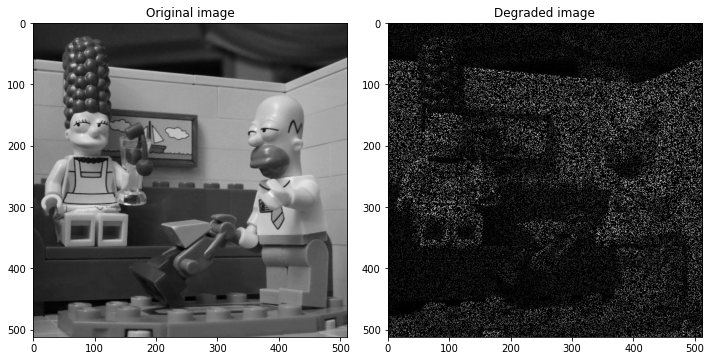

In [3]:
def printImages(a, b, title_a, title_b, size1, size2):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(size1, size1))
    axes[0].set_title(title_a)
    axes[0].imshow(a,cmap='gray',vmin=0,vmax=1)
    axes[1].set_title(title_b)
    axes[1].imshow(b,cmap='gray',vmin=0,vmax=1)
    fig.tight_layout()
    plt.show()

# Display images
printImages(u_orig, v, 'Original image', 'Degraded image', 10, 10)

In order to recover the missing values of $v$ in the mask, we propose to minimize the $TV$-based energy 

$$E(u) = \sum_{i=1}^n\sum_{j=1}^m \|(\nabla u)_{i,j}\|_2.$$ 

on the set $C$ of images taking the same values as $v$ outside of the mask.

To this aim, we can make use of a projected gradient descent : at each step of the gradient descent on $E$, we reproject the result on the constraint $\{u \in C\}$. The derivative of $E$ can be written

 $$\frac{\partial E}{\partial u} = - \mathrm{div}\left(\frac{\nabla u}{\|\nabla u\|_2}\right),$$ 

and we can replace $\|\nabla u\|_2$ by $\sqrt{\|\nabla u\|_2^2 +\varepsilon^2}$ with a small $\varepsilon$ to avoid division by $0$.

**Write a function `inpainting(v, epsilon, p, niter, mask)` implementing the algorithm described above.** The function should take as inputs the degraded image $v$, the small $\varepsilon$, the gradient step $p$, the number of iterations (try with a smaller number of iterations first) and the mask.


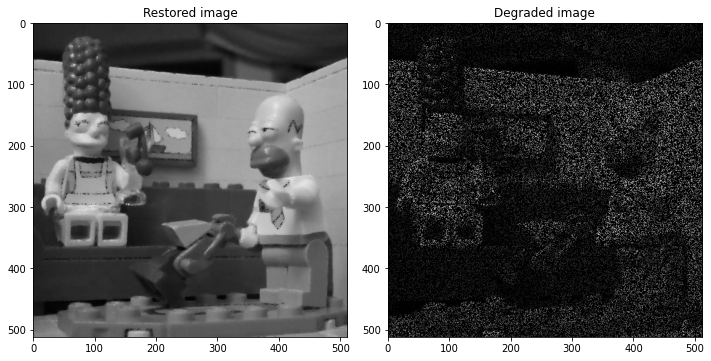

In [5]:
restoredImage = inpainting(v, epsilon=0.01, p=0.002 , niter=1000, mask=mask)

# Display images
printImages(restoredImage, v, 'Restored image', 'Degraded image', 10, 10)

## 3. Denoising

Create the noisy image by adding some Gaussian noise.

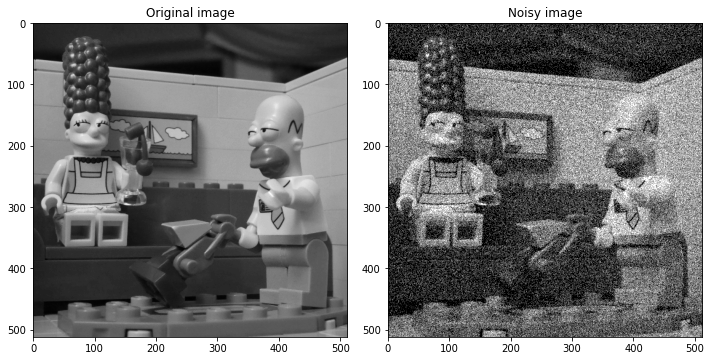

In [6]:
# Noise standard deviation
sigma = 50/255

# Add noise
u_noisy = u_orig + sigma*np.random.randn(nrow,ncol)  

# Display images
printImages(u_orig, u_noisy, 'Original image', 'Noisy image', 10, 10)

### 3.1 Tikhonov regularization

We propose to denoise $v$ by finding $u$ which minimizes 
$$E(u) = \frac{1}{2}\|u-v\|_2^2+\lambda \int \|\nabla u\|_2^2,$$ 
where $\|\nabla u\|_2$ denotes the L2-norm of $\nabla u$ in $\mathbb{R}^2$.

The formulation is convex, differentiable, so we can apply a gradient descent scheme with $$\frac{\partial E}{\partial u} =(u-v)-2\lambda\Delta u.$$

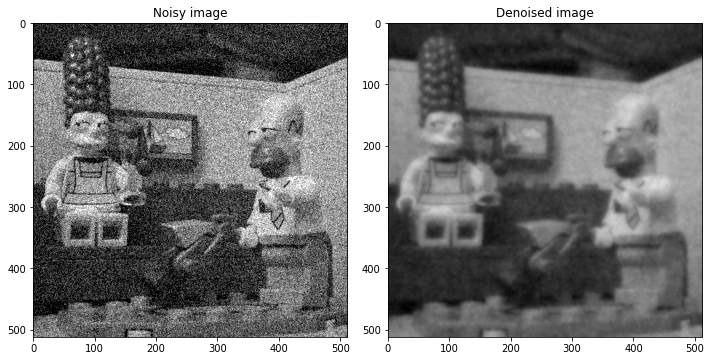

In [8]:
def tikhonov(ub, lambd, p, niter):

    u = np.copy(ub)

    for k in range(niter):  
        deltau = laplacian(u)
        u = u - p*(u - ub -2*lambd*deltau)

    return u

u = tikhonov(u_noisy, lambd = 5, p = 0.01, niter = 200)

# Display images
printImages(u_noisy, u, 'Noisy image', 'Denoised image', 10, 10)

You can also try to observe how the energy $E$ decreases through the iterations.

### 3.2 TV-L2

The Laplacian operator in the previous model does not preserve edges correctly: the result is oversmoothed. In order to preserve edges, we can replace the $L^2$ norm by a $L^1$ norm in the regularization term. The energy becomes 

$$E(u) = \frac{1}{2}\|u-v\|_2^2+\lambda TV(u),$$ 
with $TV(u)$ the discrete version of the Total Variation 

$$TV(u) =\sum_{(i,j)} \|(\nabla u)_{i,j}\|,$$ 
where $\|.\|$ is a norm on $\mathbb{R}^2$, which can be chosen as $\|.\|_1$ or $\|.\|_2$ for instance. In the following, we choose to use $\|.\|_2$.
This energy is convex but not differentiable when $\nabla u = 0$ at some points. If $\nabla u \neq 0$ everywhere, then 

$$\frac{\partial E}{\partial u} =(u-v)-\lambda \mathrm{div} \frac{\nabla u}{\|\nabla u\|}.$$ 

In practice we can apply a gradient descent by approximating $\|\nabla u\|$ by $\sqrt{\|\nabla u\|^2+\varepsilon^2}$ with a small value $\varepsilon$.

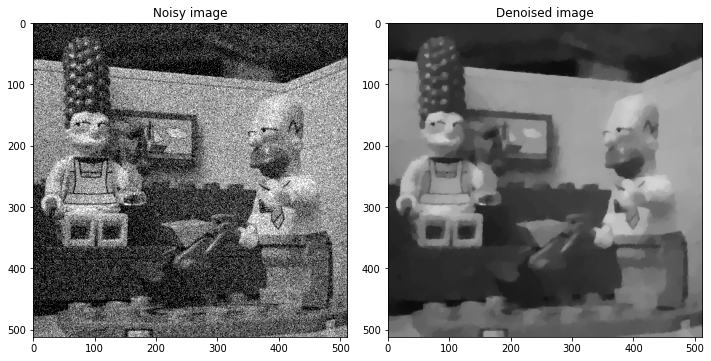

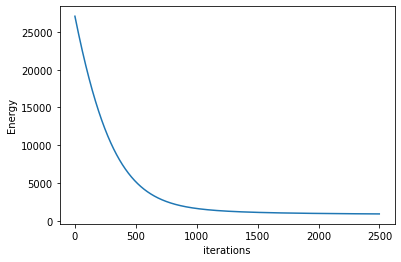

In [ ]:
def TVL2(ub, lambd, epsilon, p, niter):

    u = np.copy(ub)
    energy = []

    for i in range(N):
        ux,uy  = grad(u)
        normgrad = np.sqrt(ux**2 + uy**2 + epsilon**2)
        u = u - p * (u - ub - lambd * div(ux/normgrad,uy/normgrad))
        e = 0.5*np.linalg.norm(u-ub) + lambd*np.sum(normgrad)
        energy.append(e)

    return u, energy


N = 2500
u, energy = TVL2(u_noisy, lambd = 0.3, epsilon = 0.001, p = 0.0008, niter = N)

# Display images
printImages(u_noisy, u, 'Noisy image', 'Denoised image', 10, 10)

# Display energy through the iterations
plt.plot(range(N), energy)
plt.xlabel('iterations')
plt.ylabel('Energy')
plt.show()


Display the result and the energy $E$ through the iterations. Unfortunately, the number of iterations needed to converge is often prohibitive in practice, especially if $\varepsilon$ is chosen very small. A more convenient algorithm is proposed in the next section.

### 3.3 TV-L1

In order to minimize the convex but non-smooth energy 
$$E(u) = \|u_b-u\|_1+\lambda TV(u),$$ 

we propose to make use of a primal-dual algorithm, designed to find solutions of (smooth or non smooth) convex problems of the form (see for instance [
Antonin Chambolle, Thomas Pock. A first-order primal-dual algorithm for convex problems with applications to imaging. 2010. hal-00490826](https://hal.archives-ouvertes.fr/hal-00490826/document)): 

$$\min_{u \in X} \max_{p \in X\times X} (Ku,p) + G(u) -F^*(p),$$ 

with $K$ linear and $G: X\rightarrow \mathbb{R}^+$ and $F^*: X\rightarrow \mathbb{R}^+$ convex, proper, lower-semicontinuous.

It happens that 

$$TV(u) = \max_{p\in X\times X} <\nabla u, p >_X -\iota_{\kappa}(p),$$ 

where 

$$\iota_{\kappa}(p) = \begin{cases} 0 &\mbox{if } p\in \kappa\\ +\infty &\mbox{if } p\notin \kappa. \end{cases} \text{ and } \kappa = \{\mathrm{div} p \;/ \;\max_{x\in\Omega}|p(x)| \leq 1\}.$$ 

The TV-L1 problem can be written as a min-max under the previous form by choosing 

$$G(u) = \|u_b-u\|_1, \;\;F^*(p) =\iota_{\kappa}(p) \text{ and } K = \lambda \nabla (\text{ thus } K^* = -\lambda \mathrm{div})$$

The simple primal-dual algorithm we propose to use can be written

Initialization : choose $\tau$, $\sigma >0$, $(u^0,p^0)$
Iterations for $n\geq 0$ : 
\begin{cases} p^{n+1} &=& \underbrace{\mathrm{prox}_{\sigma F^*}}_{\text{backward step}} \underbrace{(p^n + \sigma K \bar{u}^n)}_{\text{forward step}} \\ u^{n+1} &=& \mathrm{prox}_{\tau G} (u^n-\tau K^* p^{n+1})\\ \bar{u}^{n+1} &=& u^{n+1} + \theta (u^{n+1} - u^n) \end{cases}

If $\theta=0$, the previous scheme is semi-implicit : $p^{n+1}$ is computed from $p^n$ and $u^n$, and $u^{n+1}$ is computed from $u^n$ and $p^{n+1}$. 
In the last line, $\bar{u}^{n+1}$ is a linear extrapolation, based on $u^n$ and $u^{n+1}$. It permits to make the scheme a little bit more implicit by using an updated value of $u^{n}$ when computing $p^{n+1}$.

Using the previous scheme makes sense because $\mathrm{prox}_{\sigma F^*}$ and $\mathrm{prox}_{\tau G}$ are easy to compute in the TV-L1 case : 

$$\left(\mathrm{prox}_{\tau G}(u)\right)_{i,j} = \begin{cases} u_{i,j} - \tau &\mbox{if } u_{i,j} - (u_b)_{i,j} > \tau \\ u_{i,j} + \tau &\mbox{if } u_{i,j} - (u_b)_{i,j} < -\tau \\ (u_b)_{i,j} &\mbox{if } |u_{i,j} - (u_b)_{i,j}| \leq \tau \\ \end{cases}$$ 

$$\left(\mathrm{prox}_{\sigma F^*}(p)\right)_{i,j} = \left(\pi_{\kappa}(p)\right)_{i,j} = \frac{p_{i,j}}{\max(1,|p_{i,j}|)}.$$ 

Of course, the algorithm can also be used for TV-L2, using $G(u) = \frac{1}{2}\|u_b-u\|^2_2$, then $$\left(\mathrm{prox}_{\tau G}(u)\right)_{i,j} = \frac{u_{i,j}+\tau (u_b)_{i,j}}{1+\tau} .$$ 

The convergence analysis in [
Antonin Chambolle, Thomas Pock. A first-order primal-dual algorithm for convex problems with applications to imaging. 2010. hal-00490826](https://hal.archives-ouvertes.fr/hal-00490826/document) shows that the previous algorithm converges for $\theta = 1$ if 

$$\tau\sigma.|||K|||^2 <1,\;\; \;\;\; \text{ i.e. } \;\; \;\;\tau\sigma.8\lambda^2 <1.$$

In [ ]:
def chambolle_pock_prox_TV(TV,ub,lambd,niter):
    # the function solves the problem
    # TVL2
    # argmin_u   1/2 \| u - ub\|^2 + \lambda TV(u)
    # or TVL1
    # argmin_u   1/2 \| u - ub\|_1 + \lambda TV(u)
    # with TV(u) = \sum_i \|\nabla u (i) \|_2
    # uses niter iterations of Chambolle-Pock

    nr,nc = ub.shape
    ut = np.copy(ub)
    ubar = np.copy(ut)
    p = np.zeros((nr,nc,2))
    tau = 0.9/np.sqrt(8*lambd**2)
    sigma = 0.9/np.sqrt(8*lambd**2) 
    theta = 1
    
    for k in range(niter):
        # calcul de proxF
        ux,uy  = grad(ubar)
        p = p + sigma*lambd*np.stack((ux,uy),axis=2)
        normep = np.sqrt(p[:,:,0]**2+p[:,:,1]**2)
        normep = normep*(normep>1) + (normep<=1)
        p[:,:,0] = p[:,:,0]/normep
        p[:,:,1] = p[:,:,1]/normep

        # calcul de proxG
        d=div(p[:,:,0],p[:,:,1])
        if (TV == "TVL2"):
            unew = 1/(1+tau)*(ut+tau*lambd*d+tau*ub) 
        else:
            uaux = ut+tau*lambd*d
            unew = (uaux-tau)*(uaux-ub>tau)+(uaux+tau)*(uaux-ub<-tau)+ub*(abs(uaux-ub)<=tau)
        
        #extragradient step
        ubar = unew+theta*(unew-ut)
        ut = np.copy(unew)
           
    return ut

- TVL2 for addtive noise removal : compare the result of the TV-L2 algorithm implemented before (with the $\epsilon$ regularization) with the one obtained with the Chambolle-Pock scheme.


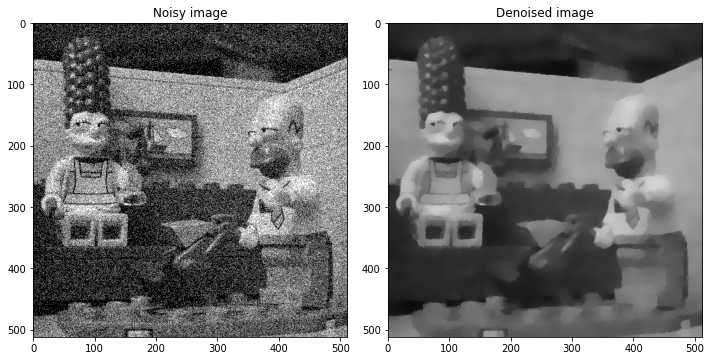

In [ ]:
u = chambolle_pock_prox_TV("TVL2",u_noisy,0.3,300)

# Display images
printImages(u_noisy, u, 'Noisy image', 'Denoised image', 10, 10)

- Impulse noise : compare now the result of TV-L1 and TV-L2 to denoise an image corrupted with impulse noise. Recall that impulse noise of parameter $p$ can be added to an image $f$ by replacing randomly a proportion $p$ of all pixels by values drawn uniformly on the image range ($[0,1]$ here).

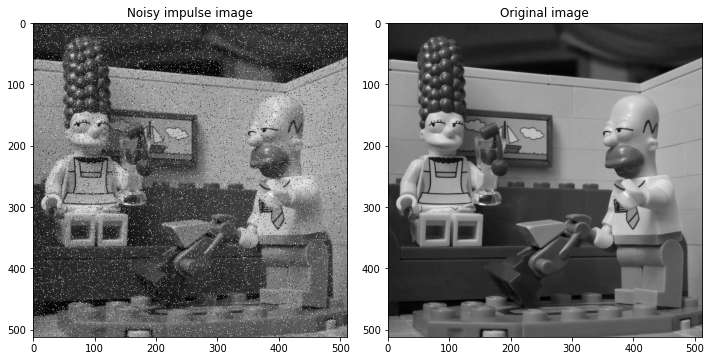

In [ ]:
p = 0.1
I = np.random.rand(nrow,ncol)
u_noisy_impulse = 1*np.random.rand(nrow,ncol)*(I<p)+(I>=p)* u_orig

# Display images
printImages(u_noisy_impulse, u_orig, 'Noisy impulse image', 'Original image', 10, 10)

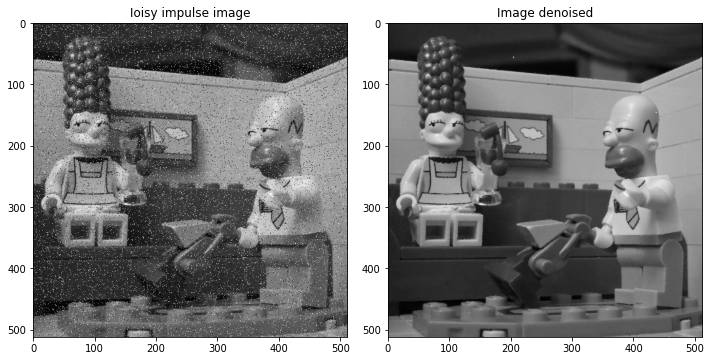

In [ ]:
u = chambolle_pock_prox_TV("TVL1",u_noisy_impulse,0.5,200)

# Display image u and noisy image v
printImages(u_noisy_impulse, u, 'Ioisy impulse image', 'Image denoised', 10, 10)

Explain why the TV-L1 restoration is better than TV-L2 to remove impulse Noise.

## 4. Deconvolution with periodicity (using Fourier)

In this section, the observed image $u_b$ degraded by a blur and an additive noise can be written as:
$$u_b = Au+\varepsilon$$
where the operator $A$ represents a (circular) convolution with a known kernel $k$. For the sake of simplicity we propose to use a uniform kernel for $k$ but you can try other kinds of kernels. The matrix $A$ is never computed explicitly (it would be HUGE!), all operations involving $A$ or $A^*$ must be written directly in the Fourier domain. For instance:  
- $Au$ is a convolution with the kernel $k$, it can be computed as 
$$\mathcal{F}^{-1} ( \hat{u}. \hat{k} )$$
with $\mathcal{F}$ the Fourier transform and $\mathcal{F}^{-1}$ the inverse Fourier transform.
- $A^*u$ is a convolution with the conjugate of the kernel $k$.
- the inversion $(Id+\sigma AA^*)^{-1} u $ in the Fourier domain becomes a division  $\frac{\hat{u}}{1+ \sigma |\hat{k}|^2}$

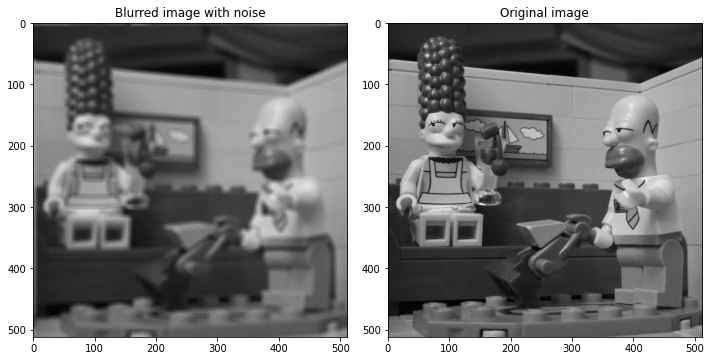

In [ ]:
# convolution assuming a periodic signal
def convol_periodic(a,b):
    return np.real(np.fft.ifft2(np.fft.fft2(a)*np.fft.fft2(b))) 

#kernel definition (for a 9x9 uniform kernel)
s=4 
k_uniform = np.zeros((nrow,ncol))
k_uniform[0:2*s+1,0:2*s+1] = np.ones((2*s+1, 2*s+1))/(2*s+1)**2

# blurred image with noise
u_blurred = convol_periodic(u_orig,k_uniform) + 0.01*np.random.randn(nrow,ncol)

# Display images
printImages(u_blurred, u_orig, 'Blurred image with noise', 'Original image', 10, 10)

### 4.1 Wiener deconvolution

A classic approach to retrieve $u$ in the presence of noise is Wiener filtering. The idea is to find a linear filter $w$ which minimizes the expected mean square error 
$$\arg\min_w \; \mathbb{E}[\|w* u_b - u\|_2^2].$$ 

Now, thanks to Parseval identity, this error can be rewritten in the Fourier domain as $$\arg\min_w \; \mathbb{E}[\|\hat{w}\hat{u_b} - \hat{u}\|_2^2],$$ and the filter $w$ which minimizes this quantity is 

$$\widehat{w} = \frac{\mathbb{E}[\hat{u}\;\overline{\hat{u_b}}]}{\mathbb{E}[|\hat{u_b}|^2]} = \frac{\overline{\hat{k}}}{|\hat{k}|^2 + \frac{\mathbb{E}[|\hat{\varepsilon}|^2]}{\mathbb{E}[|\hat{u}|^2]}}.$$ 

In practice, we can for instance replace the unknown noise to signal ratio $\frac{\mathbb{E}[|\hat{\varepsilon}|^2]}{\mathbb{E}[|\hat{u}|^2]}$ by a well chosen constant value.

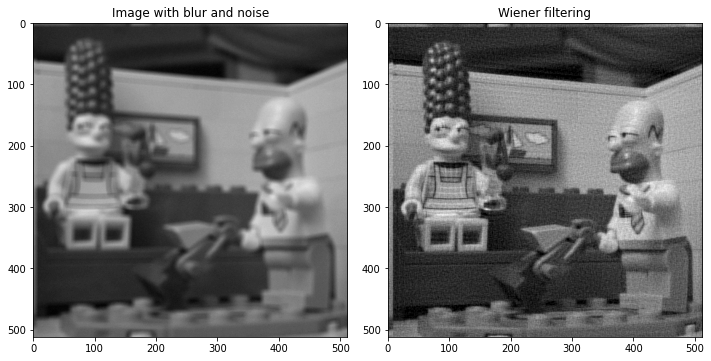

In [ ]:
#Wiener filtering for deconvolution
def wiener(ub, k, NSR):
    
    khat = np.fft.fft2(k)
    ubhat = np.fft.fft2(ub)
    what = khat/(abs(khat)**2+ NSR)
    uhat = what*ubhat
    u =np.real((np.fft.ifft2(uhat)))
    return u


NSR = 1/200         # noise / signal estimated ratio
u = wiener(u_blurred, k_uniform, NSR)

# Display images
printImages(u_blurred, u, 'Image with blur and noise', 'Wiener filtering', 10, 10)

### 4.2 TV-L2 deblurring (periodic case)


As an alternative to Wiener filtering, we can solve the following optimization problem \begin{equation} \arg\min_u\; E(u),\;\;\;\; \text{ with }\;\;\;\;E(u) = \underbrace{\frac{1}{2}\|Au-u_b\|_2^2}_{G(u)}+\lambda TV(u). \end{equation} 

We propose to use the Chambolle-Pock algorithm described above to this aim. Basically, the algorithm will follow the same structure as before, the only  change concerns the computation of $prox_G$, which will now use the convolution operator $A$. 
Using the same notations as before, the update over $u$ becomes

$$u^{n+1} = \mathrm{prox}_{\tau G} (u^n-\tau K^* p^{n+1}) = (Id+\tau A A^*)^{-1}\left(u^n  + \lambda \tau  \mathrm{div}(p^{n+1})+\tau A^* ub\right)$$



Since all operations can be written in the Fourier domain, the resulting algorithm remains simple. When $A$ is not a periodic convolution, computing the inverse of $(Id+\tau A A^*)$ is not possible numerically, we will see later how to handle this case.

Try to apply this algorithm to the blurred version of u, with or without noise added to the blurred image. How should be chosen the regularization parameter λ in each case?

In [ ]:
def IdplustauATA_inv(x,tau,h): 
    return np.real(np.fft.ifft2(np.fft.fft2(x)/(1+tau*np.abs(np.fft.fft2(h))**2)))

def chambolle_pock_deblurring_TVL2(ub,h,lambd,niter):
    # the function solves the problem
    # argmin_u   1/2 \| Au - ub\|^2 + \lambda TV(u)
    # with TV(u) = \sum_i \|\nabla u (i) \|_2
    # and A = blur given by a kernel h
    # uses niter iterations of Chambolle-Pock

    nr,nc = ub.shape
    ut = np.copy(ub)

    p = np.zeros((nr,nc,2))
    tau   = 0.9/np.sqrt(8*lambd**2)
    sigma = 0.9/np.sqrt(8*lambd**2) 
    theta = 1
    ubar = np.copy(ut)
    
    h_fft = np.fft.fft2(h)
    hc_fft = np.conj(h_fft)
    hc = np.fft.ifft2(hc_fft)

    for k in range(niter):
        
        # subgradient step on p 
        ux,uy  = grad(ubar)
        p = p + sigma*lambd*np.stack((ux,uy),axis=2)
        normep = np.sqrt(p[:,:,0]**2+p[:,:,1]**2)
        normep = normep*(normep>1) + (normep<=1)
        p[:,:,0] = p[:,:,0]/normep
        p[:,:,1] = p[:,:,1]/normep
        
        # subgradient step on u
        d=div(p[:,:,0],p[:,:,1])
        unew = (ut+tau*lambd*d+tau*convol_periodic(ub, hc)) 
        unew = IdplustauATA_inv(unew, tau,h)
    
        #extragradient step on u 
        ubar = unew+theta*(unew-ut)
        ut = np.copy(unew)
        
    return ut

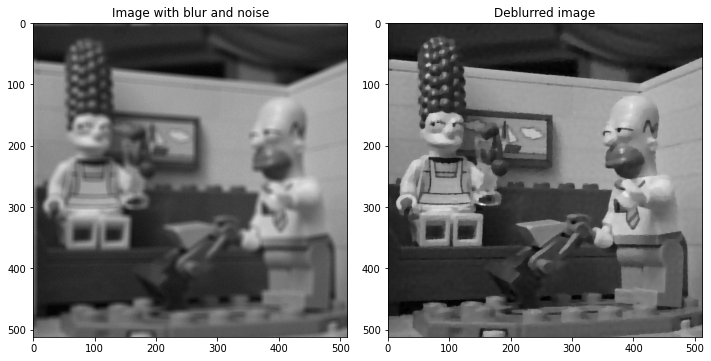

In [ ]:
# TVL2 deblurring
u = chambolle_pock_deblurring_TVL2(u_blurred,k_uniform,lambd = 1e-3,niter = 200) 

# Display the result
printImages(u_blurred, u, 'Image with blur and noise', 'Deblurred image', 10, 10)

## 5. Deconvolution without assuming periodicity

If the convolution is not periodic, the previous approch is no longer possible, since we cannot compute $(Id+\tau A A^*)^{-1}$ numerically. An alternative approach in this case is to use a double splitting scheme to minimize our energy.


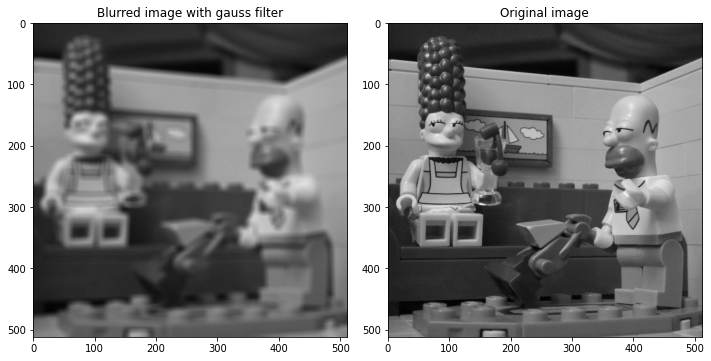

In [ ]:
def gaussFilter(shape,sigma):

    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def convol_aperiodic(a,b):
    return scipy.signal.convolve2d(a,b, boundary='symm', mode='same')

# blurred image with gauss filter
k_gauss = gaussFilter(shape=(11,11), sigma=10)
u_blurred_gauss = convol_aperiodic(u_orig,k_gauss)

# Display images
printImages(u_blurred_gauss, u_orig, 'Blurred image with gauss filter', 'Original image', 10, 10)

We still want to solve the  optimization problem \begin{equation} \arg\min_u\; E(u),\;\;\;\; \text{ with }\;\;\;\;E(u) = \frac{1}{2}\|Au-u_b\|_2^2+\lambda TV(u). \end{equation} 

$E$ is convex but not smooth, so we will use the same primal-dual algorithm described for minimizing TVL1. To this aim, we note again that 
$$TV(u) = \max_{p\in X\times X} <\nabla u, p >_X -\iota_{\kappa}(p),$$ 
where 
$$\iota_{\kappa}(p) = \begin{cases} 0 &\mbox{if } p\in \kappa\\ +\infty &\mbox{if } p\notin \kappa. \end{cases} \text{ and } \kappa = \{\mathrm{div} p \;/ \;\max_{x\in\Omega}|p(x)| \leq 1\}.$$ 

The same duality trick can now be used to rewrite $\|Au-u_b\|_2^2$ as

$$ \frac 1 2 \|Au-u_b\|_2^2 = \max_{q \in X} < Au , q > - \frac{1}{2} \|q\|_2^2- < q , u_b >.$$

This double splitting permits to rewrite the primal deconvolution problem under the form 

$$\min_{u \in X} \max_{p \in X\times X;\,q \in X} (Ku,(p,q)) + G(u) -F^*(p,q),$$ 
with $K = (\lambda \nabla,A)$ linear, $G = 0$ and $F^* = <q,u_b> +\frac 1 2 \|q\|^2 + \iota_{\kappa}(p)$.

$\mathrm{prox}_{\sigma G}$ is the identity and computing $\mathrm{prox}_{\sigma F^*}$ is easy since the function is separable in $p$ and $q$ : 
$$ \left(\mathrm{prox}_{\sigma F^*}(p,q)\right)_{i,j} = \begin{pmatrix} \frac{p_{i,j}}{\max(1,|p_{i,j}|)} \\ \frac{q_{i,j}-\sigma u_b}{1+\sigma} \end{pmatrix}. $$ 

The complete algorithm can be written

Initialization : choose $\tau$, $\sigma >0$, $(u^0,p^0)$
Iterations for $n\geq 0$ : 

\begin{cases} (p^{n+1},q^{n+1}) &=& \underbrace{\mathrm{prox}_{\sigma F^*}}_{\text{backward step}} \underbrace{((p^n,q^n) + \sigma K \bar{u}^n)}_{\text{forward step}} = \mathrm{prox}_{\sigma F^*} (p^n+\sigma\lambda \nabla \bar{u}^n,q^n + \sigma A \bar{u}^n)\\ u^{n+1} &=& \mathrm{prox}_{\tau G} (u^n-\tau K^* p^{n+1}) = u^n-\tau K^* p^{n+1} = u^n + \tau \lambda \mathrm{div} p^{n+1} -\tau A^*q^{n+1} \\ \bar{u}^{n+1} &=& u^{n+1} + \theta (u^{n+1} - u^n) \end{cases}

To ensure convergence, $\tau$ and $\sigma$ must be chosen such that $$\tau\sigma.(8\lambda^2 + \|k\|_1^2) <1.$$ 

If the discrete convolution $k*u$ is defined by extending $u$ by $0$ outside of its domain, then the adjoint $A^*$ is the convolution operator with the kernel $k_s$ obtained by symmetrizing $k$ (be careful in practice to use only odd size for kernels).

Write a function `tvdeconv(ub,k,lambd,niter)` using the previous algorithm to minimize $E$ (*k* is the convolution kernel and *niter* the number of iterations).


In [ ]:
# Deconvolution with double splitting and known kernel
def tvdeconv(ub,k,lambd,niter):

    # kernel
    k = k/np.sum(k)
    normk = np.sum(np.abs(k))
    kstar = k[::-1,::-1]

    #initialization
    nr,nc = ub.shape
    ut = np.copy(ub)
    ubar = np.copy(ub)

    p = np.zeros((nr,nc,2))
    q = np.zeros((nr,nc))
    tau   = 0.9/np.sqrt(8*lambd**2 + normk**2)
    sigma = tau
    theta = 1
    
    #Double splitting
    for i in range(niter):
        #INSERT YOUR CODE HERE   

    return ut

Use the previous function to restore an image degraded with different kinds of blur (gaussian, motion, average, etc). Be careful to use only odd dimensions for kernels !!! In this ideal case without noise, the blur can be perfectly removed if the $A$ matrix can be inverted. In practice, this can be approached by choosing a very small value for $\lambda$.

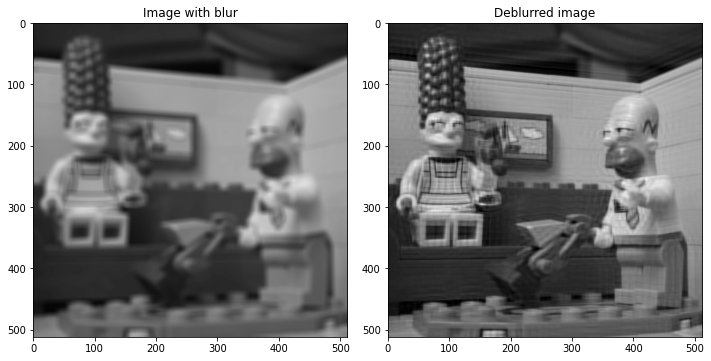

In [ ]:
# Example with gaussian blur and no noise

# Variational deblurring
u = tvdeconv(u_blurred_gauss, k_gauss, lambd = 0.0001, niter = 200) 

# Display the result
printImages(u_blurred_gauss, u, 'Image with blur', 'Deblurred image', 10, 10)

Try the same approach for an image degraded by blur and additive gaussian noise. In presence of noise, TV regularization becomes necessary, and $\lambda$ must be chosen larger.

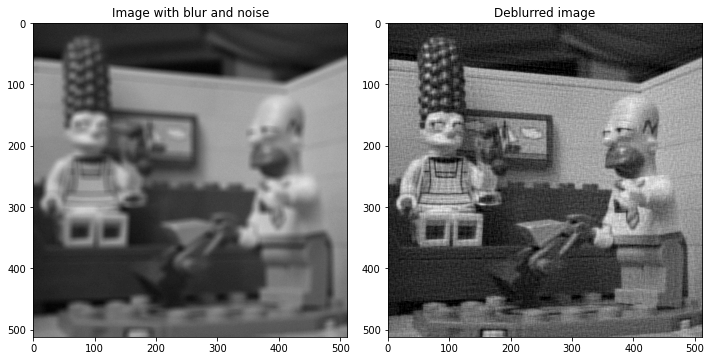

In [ ]:
# Example with blur and noise
u_blurred_gauss2 = convol_aperiodic(u_orig,k_gauss) + 0.01*np.random.randn(nrow,ncol)

# Variational deblurring
u = tvdeconv(u_blurred_gauss2,k_gauss,lambd = 0.001, niter = 200) 

# Display the result
printImages(u_blurred_gauss2, u, 'Image with blur and noise', 'Deblurred image', 10, 10)